# Step 1: Data Preparation

In [87]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pickle
import string
from tqdm.notebook import tqdm
tqdm().pandas()
import os

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate, Reshape
from keras.layers.merging import add
from keras.utils import to_categorical
from keras.utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing import image
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

0it [00:00, ?it/s]

In [2]:
gpus = tf.config.list_physical_devices()
tf.config.experimental.set_visible_devices(gpus[1], "GPU")

In [3]:
# read caption data
file_path8k = "./archive/captions.csv"
file_path30k = "./archive30k/flickr30k_images/results.csv"
path8kimages = "./archive/Images"
path30kimages = "./archive30k/flickr30k_images/flickr30k_images/"

In [103]:
def show_data(path, captions, img_id="random"):
    if img_id == "random":
        ids = list(captions.keys())
        x = np.random.randint(0, len(ids))
        img_id = ids[x]
    im = cv2.imread(path + "/" +img_id, cv2.IMREAD_COLOR)
    print(captions[img_id])
    plt.imshow(im)

In [5]:
# storing captions in a dictionary
def read_captions(file_path, delim=",", pos=1):
    vocab = set()
    captions = pd.read_csv(file_path, delimiter=delim)
    img_captions = dict()
    vocab.add("startsq")
    vocab.add("endsq")
    for i in range(captions.shape[0]):
        img_id = captions.iloc[i][0]
        cleaned_caption = []
        caption = captions.iloc[i][pos]
        for w in caption.split():
            w = w.translate(str.maketrans('', '', string.punctuation))
            if len(w) <= 1 or not w.isalpha():
                continue
            w = w.lower()
            vocab.add(w)
            cleaned_caption.append(w)
        caption = "startsq " + " ".join(cleaned_caption) + " endsq"
        if img_id not in img_captions.keys():
            img_captions[img_id] = list()
        img_captions[img_id].append(caption)
    return img_captions, captions, vocab

In [6]:
# reading and preparing data for flicker8k dataset
image_captions8, captions_df8, vocab8 = read_captions(file_path8k)

# reading and preparing data for flicker30k dataset
# image_captions30, captions_df30, vocab30 = read_captions(file_path30k, "|", 2)

['startsq child holding up sign with skull and crossbones endsq', 'startsq child wearing pirates costume holds up skull and crossbones sign endsq', 'startsq little boy dressed as pirate holding up skull and crossbones flag endsq', 'startsq little boy dressed as pirate is holding up the skull pirate flag endsq', 'startsq young boy dressed like pirate is holding sign with skull and crossbones on it endsq']


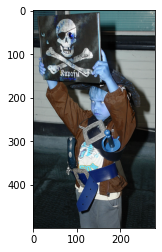

In [110]:
show_data(path8kimages, image_captions8)
# show_data(path30kimages, image_captions30)


In [8]:
print(f"Length of the vocabulary: {len(vocab8)}")

# print(f"Length of the vocabulary: {len(vocab30)}")


Length of the vocabulary: 8765


In [9]:
# word to index
def word_to_index(vocab):
    word_indx = {}
    indx_word = {}
    i = 0
    for w in vocab:
        word_indx[w] = i
        indx_word[i] = w
        i += 1 
    return word_indx, indx_word

In [10]:
word_indx8, indx_word8 = word_to_index(vocab8)

# word_indx30, indx_word30 = word_to_index(vocab30)

In [11]:
# word embedding weights
def load_embedding(filename):
    embeddings = {}
    GloVe_data = open(filename, "r", encoding="utf-8")
    for line in GloVe_data:
        line = line.split()
        word = line[0]
        vec = np.asarray(line[1:], dtype='float32')
        embeddings[word] = vec
    GloVe_data.close()
    return embeddings

def fill_embedding_weights(embeddings, word_indx, embed_dim, vocab_len):
    embedding_weights = np.zeros((vocab_len, embed_dim))
    for w, i in word_indx.items():
        vec = embeddings.get(w)
        if vec is not None:
            embedding_weights[i] = vec
    return embedding_weights
    
def get_max_length(desc):
    all_captions = []
    for _, captions in desc.items():
        for c in captions:
            all_captions.append(c)
    return max([len(caption.split()) for caption in all_captions])

In [12]:
glove_path = "./glove.42B.300d.txt"
embeddings_index = load_embedding(glove_path)

In [13]:
vocab_len = len(vocab8)
embedding_dim = 300

embedding_weights = fill_embedding_weights(embeddings_index, word_indx8, embedding_dim, vocab_len)
max_length = get_max_length(image_captions8)

# vocab_len = len(vocab30)
# embedding_dim = 300

# embedding_weights = fill_embedding_weights(embeddings_index, word_indx30, embedding_dim, vocab_len)
# max_length = get_max_length(image_captions30)

In [113]:
max_length = get_max_length(image_captions8)

with open("word_indx8.pickle", "wb") as output:
    pickle.dump(word_indx8, output, protocol=pickle.HIGHEST_PROTOCOL)

with open("indx_word8.pickle", "wb") as output:
    pickle.dump(indx_word8, output, protocol=pickle.HIGHEST_PROTOCOL)

with open("max_length8.pickle", "wb") as output:
    pickle.dump(max_length, output, protocol=pickle.HIGHEST_PROTOCOL)

# Step 2: Feature Extraction from Images

In [53]:
features = {}

vgg16_model = VGG16()
vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-2].output)


def extract_features(path, img_id, model):
    filename = path + "/" + img_id
    img = image.load_img(filename, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = model.predict(img)
    return features

# i = 1
# for img in tqdm(os.listdir(path8kimages)):
#     print(i)
#     features[img] = extract_features(path8kimages, img, vgg16_model)
#     i += 1

# with open("image_features.pickle", "wb") as output:
#     pickle.dump(features, output, protocol=pickle.HIGHEST_PROTOCOL)

# i = 1
# for img in tqdm(os.listdir(path30kimages)):
#     print(i)
#     features[img] = extract_features(path30kimages, img, vgg16_model)
#     i += 1

# with open("image_features30k.pickle", "wb") as output:
#     pickle.dump(features, output, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/31783 [00:00<?, ?it/s]

1
1/1 [==============================] - 5s 5s/step
2
1/1 [==============================] - 0s 29ms/step
3
1/1 [==============================] - 0s 28ms/step
4
1/1 [==============================] - 0s 29ms/step
5
1/1 [==============================] - 0s 20ms/step
6
1/1 [==============================] - 0s 22ms/step
7
1/1 [==============================] - 0s 28ms/step
8
1/1 [==============================] - 0s 21ms/step
9
1/1 [==============================] - 0s 21ms/step
10
1/1 [==============================] - 0s 21ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 26ms/step
13
1/1 [==============================] - 0s 21ms/step
14
1/1 [==============================] - 0s 19ms/step
15
1/1 [==============================] - 0s 19ms/step
16
1/1 [==============================] - 0s 20ms/step
17
1/1 [==============================] - 0s 19ms/step
18
1/1 [==============================] - 0s 19ms/step
19
1/1 [=============

In [14]:
def load_feature(file_name):
    f = open(file_name, "rb")
    features = pickle.load(f)
    f.close()
    return features

In [15]:
features = load_feature("./image_features.pickle")
# features30 = load_feature("./image_features30k.pickle")

# Step 3: Generate Data for Training

In [16]:
# split data into train, validation and test sets
indeces = np.array(np.arange(0, len(image_captions8)))
train, test_and_val = train_test_split(indeces, test_size=0.1, random_state=42)
val, test = train_test_split(test_and_val, test_size=0.5, random_state=42)


train_ids = [list(image_captions8.keys())[i] for i in train]
val_ids = [list(image_captions8.keys())[i] for i in test_and_val]
# test_ids = [list(image_captions8.keys())[i] for i in test]

# train_ids = [list(image_captions30.keys())[i] for i in train]
# val_ids = [list(image_captions30.keys())[i] for i in val]
# test_ids = [list(image_captions30.keys())[i] for i in test]

In [17]:
def create_generator(features, captions, wordtoix, max_length, batch_size, ids):
    x1 = []
    x2 = []
    y = []
    n = 0
    while True:
        for img_id in ids:
            desc = captions[img_id]
            n += 1
            img_feature = features[img_id][0]
            for c in desc:
                caption_seq = [wordtoix[w] for w in c.split(" ") if w in wordtoix]
                for i in range(1, len(caption_seq)):
                    x1.append(img_feature)
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding="post")[0]
                    x2.append(in_seq)
                    out_seq = to_categorical([out_seq], num_classes=vocab_len)[0]
                    y.append(out_seq)
            if n == batch_size:
                yield [np.array(x1), np.array(x2)], np.array(y)
                x1, x2, y = [], [], []
                n = 0   


# Step 4: Build the Model

In [18]:
def build_model():
    inputs1 = Input(shape=(4096,))
    dropout_inputs1 = Dropout(0.5)(inputs1)
    image_features_compressed = Dense(300, activation="relu")(dropout_inputs1)
    image_features_compressed_reshaped = Reshape((1, 300), input_shape=(300,))(image_features_compressed)

    inputs2 = Input(shape=(max_length,))
    embedding_string_sequence = Embedding(vocab_len, embedding_dim)(inputs2)
    merged = concatenate([image_features_compressed_reshaped, embedding_string_sequence], axis=1)
    dropout_merged = Dropout(0.5)(merged)
    lstm_network = LSTM(512, activation='relu')(dropout_merged)
    
    # merging_layers = add([image_features_compressed, lstm_network])
    decoder = Dense(1024, activation='relu')(lstm_network)
    output = Dense(vocab_len, activation='softmax')(decoder)

    model = Model(inputs=[inputs1, inputs2], outputs=output)
    return model

In [45]:
model = build_model()
model.layers[5].set_weights([embedding_weights])
model.layers[5].trainable = False
model.compile(loss="categorical_crossentropy", optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout_4 (Dropout)            (None, 4096)         0           ['input_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 300)          1229100     ['dropout_4[0][0]']              
                                                                                                  
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                            

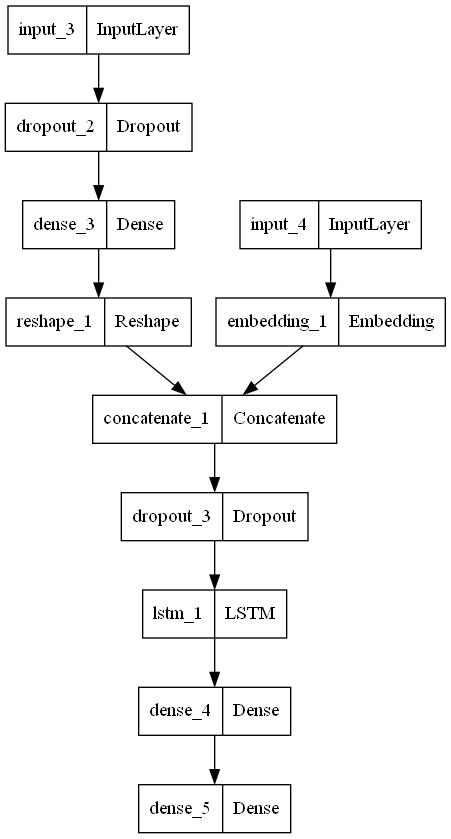

In [41]:
plot_model(model)

In [21]:
# clear memory
del captions_df8
del embeddings_index

# Step 5: Train the Model

In [43]:
max_length

34

In [46]:
train_generator = create_generator(features, image_captions8, word_indx8, max_length, 32, train_ids)

model.fit_generator(train_generator, len(train_ids)//32, epochs=30, verbose=1)
# model.save("8k")

# train_generator = create_generator(features30, image_captions30, word_indx30, max_length, 32, train_ids)
# model.fit_generator(train_generator, len(train_ids)//32, epochs=15, verbose=1)
# model.save("30k_model")

C:\Users\hka20\AppData\Local\Temp\ipykernel_10196\3437548854.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, len(train_ids)//32, epochs=30, verbose=1)


Epoch 1/30
227/227 [==============================] - 72s 312ms/step - loss: 5.9901
Epoch 2/30
227/227 [==============================] - 70s 308ms/step - loss: 5.3092
Epoch 3/30
227/227 [==============================] - 68s 300ms/step - loss: 4.8359
Epoch 4/30
227/227 [==============================] - 65s 287ms/step - loss: 4.5465
Epoch 5/30
227/227 [==============================] - 66s 289ms/step - loss: 4.2114
Epoch 6/30
227/227 [==============================] - 66s 290ms/step - loss: 3.9532
Epoch 7/30
227/227 [==============================] - 69s 304ms/step - loss: 3.7466
Epoch 8/30
227/227 [==============================] - 65s 286ms/step - loss: 3.5876
Epoch 9/30
227/227 [==============================] - 65s 288ms/step - loss: 3.4501
Epoch 10/30
227/227 [==============================] - 68s 301ms/step - loss: 3.3302
Epoch 11/30
227/227 [==============================] - 66s 291ms/step - loss: 3.2206
Epoch 12/30
227/227 [==============================] - 65s 286ms/step - lo

In [61]:
model.save("8k")

INFO:tensorflow:Assets written to: 8k\assets


# Step 6: Test and Analyze Performance

In [23]:
def print_prediction(model, img_id, word_indx, indx_word, max_lngth):
    img_feature = features[img_id]
    in_text = "startsq"
    for i in range(max_lngth):
        in_seq = [word_indx[w] for w in in_text.split(" ")]
        in_seq = pad_sequences([in_seq], maxlen=max_lngth, padding="post")[0]
        in_seq = np.array([in_seq])
        pred = model.predict([img_feature, in_seq], verbose=0)
        pred = np.argmax(pred)
        word = indx_word.get(pred)
        if word is None:
            print("none")
            break
        in_text += " " + word
        if word == "endsq":
            break
    return in_text
    

startsq brown dog is running through the grass endsq
['startsq cream colored dog runs through green grass endsq', 'startsq dog runs through the grass endsq', 'startsq recently adopted mixed breed medium sized dog bounds happily around the yard endsq', 'startsq yellow dog running across lawn endsq', 'startsq yellow dog runs through the grass endsq']


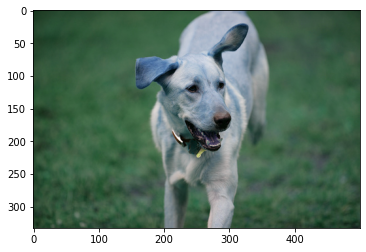

In [60]:
x = list(image_captions8.keys())
x = len(x)
x = np.random.randint(1, x)
image_id = list(image_captions8.keys())[x]
# print(image_captions8[image_id])
print(print_prediction(model, image_id, word_indx8, indx_word8, max_length))
show_data(path8kimages, image_captions8, image_id)

In [90]:
def evaluate_model(model, descrption, features, word_indx, indx_word, max_length, ids):
    actual = []
    predicted = []
    x = 0
    for img_id in ids:
        x += 1
        desc = descrption[img_id]
        y_pred = print_prediction(model, img_id, word_indx, indx_word, max_length)
        y_true = [d.split() for d in desc]
        actual.append(y_true)
        predicted.append(y_pred.split())
    print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))}")
    print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")
    print(f"BLEU-3: {corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))}")
    print(f"BLEU-4: {corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))}")
         

In [91]:
# model = keras.models.load_model("8k_model")
evaluate_model(model, image_captions8, features, word_indx8, indx_word8, max_length, val_ids)

BLEU-1: 0.5453871762771526
BLEU-2: 0.3102426778576116
BLEU-3: 0.2271176771922608
BLEU-4: 0.11728357078767628


['startsq group of teenagers near simpsons characters endsq', 'startsq group of teenagers standing outside of convienance store endsq', 'startsq four young people with cold drinks stand on the sidewalk in front of cartoon cutouts of the simpsons also holding cold drinks endsq', 'startsq three people stand outside fast food joint with their drinks endsq', 'startsq three teenagers drink slurpees outside convienience store endsq']


'startsq man in red shirt is standing in front of topless statue endsq'

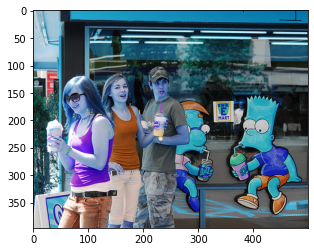

In [109]:
x = list(image_captions8.keys())
x = len(x)
x = np.random.randint(1, x)
image_id = list(image_captions8.keys())[x]
show_data(path8kimages, image_captions8, image_id)
print_prediction(model, image_id, word_indx8, indx_word8, max_length)

# x = list(image_captions30.keys())
# x = len(x)
# x = np.random.randint(1, x)
# image_id = list(image_captions30.keys())[x]
# print(image_captions30[image_id])
# print_prediction(model, image_id, word_indx30, indx_word30, max_length)